# Embedding large data sets

Embedding large data sets typically requires more care. Using various tricks described in *preserving_global_structure* can become quite slow to run. Instead, we can take a smaller, manageable sample of our data set, obtain a good visualization of that. Then, we can add the remaining points to the embedding and use that as our initialization.

Remember that the initialization largely affects the structure of the embedding. This way, our initialization provides the global structure for the embedding, and the subsequent optimization can focus on preserving local strucutre.

In [1]:
from openTSNE import TSNE, TSNEEmbedding, affinity, initialization
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np

import matplotlib.pyplot as plt

## Load data

In [2]:
import gzip
import pickle

with gzip.open("data/10x_mouse_zheng.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"]

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 1306127 samples with 50 features


In [4]:
def plot(x, y, **kwargs):
    utils.plot(
        x,
        y,
        colors=utils.MOUSE_10X_COLORS,
        alpha=kwargs.pop("alpha", 0.1),
        draw_legend=False,
        **kwargs,
    )

In [5]:
def rotate(degrees):
    phi = degrees * np.pi / 180
    return np.array([
        [np.cos(phi), -np.sin(phi)],
        [np.sin(phi), np.cos(phi)],
    ])

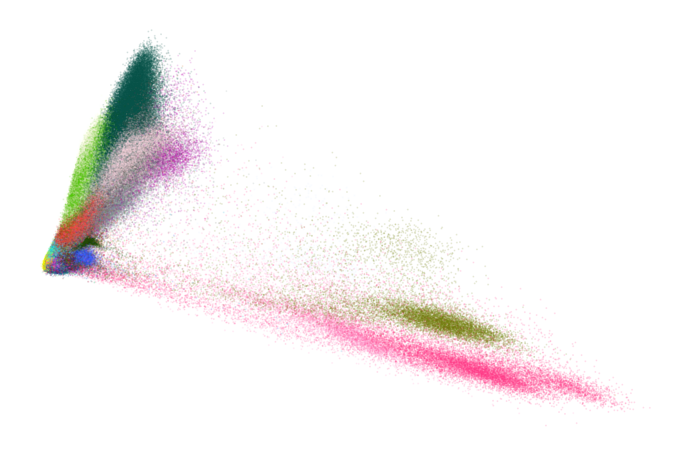

In [6]:
plot(x, y)

We'll also precompute the full affinities, since we'll be needing it in several places throughout the notebook, and can take a long time to run.

In [7]:
%%time
affinities = affinity.PerplexityBasedNN(
    x,
    perplexity=30,
    n_jobs=8,
    random_state=0,
)

CPU times: user 38min 48s, sys: 13.6 s, total: 39min 1s
Wall time: 25min 3s


## Standard t-SNE

First, let's see what standard t-SNE does.

In [8]:
%time init = initialization.pca(x, random_state=0)

CPU times: user 17.6 s, sys: 1.36 s, total: 19 s
Wall time: 3.19 s


In [9]:
embedding_standard = TSNEEmbedding(
    init,
    affinities,
    negative_gradient_method="fft",
    n_jobs=8,
)

In [10]:
%%time
embedding_standard.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
embedding_standard.optimize(n_iter=750, exaggeration=1, momentum=0.8, inplace=True)

CPU times: user 2h 23min 6s, sys: 2min 8s, total: 2h 25min 15s
Wall time: 18min 46s


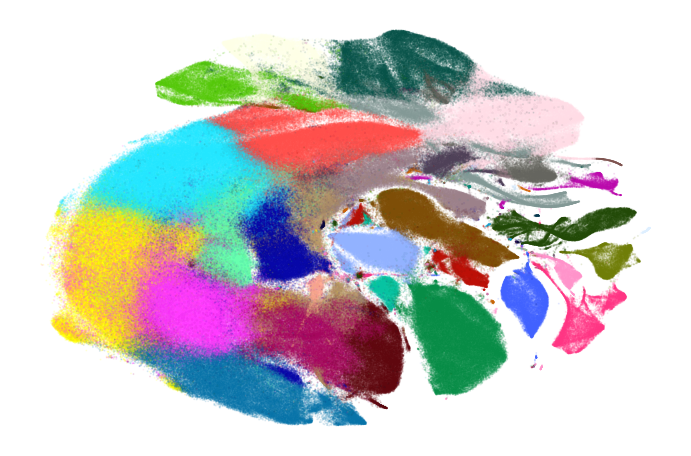

In [11]:
plot(embedding_standard, y)

This doesn't look too great. The cluster separation is quite poor and the visualization is visually not very appealing.

## Using exaggeration

Exaggeration can be used in order to get better separation between clusters. Let's see if that helps.

In [12]:
%time init = initialization.pca(x, random_state=0)

CPU times: user 17.1 s, sys: 1.22 s, total: 18.3 s
Wall time: 3.07 s


In [13]:
embedding_exag = TSNEEmbedding(
    init,
    affinities,
    negative_gradient_method="fft",
    n_jobs=8,
)

In [14]:
%%time
embedding_exag.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
embedding_exag.optimize(n_iter=750, exaggeration=4, momentum=0.8, inplace=True)

CPU times: user 2h 24min 55s, sys: 12min, total: 2h 36min 55s
Wall time: 27min 22s


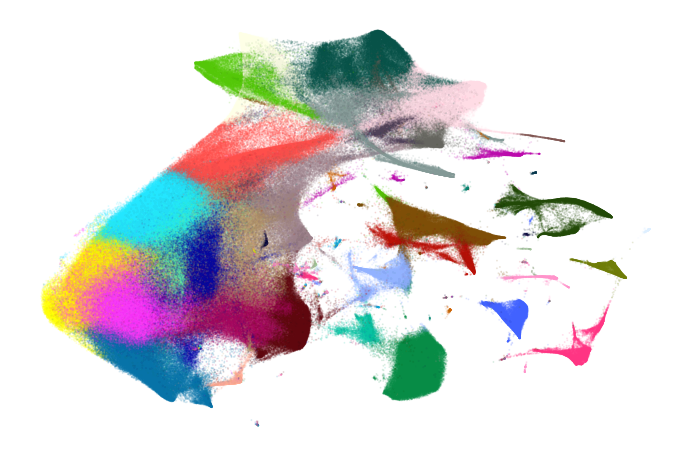

In [15]:
plot(embedding_exag, y)

The separation has improved quite a bit, but many clusters are still intertwined with others.

## With downsampling

We now perform the sample-transform trick we described above.

### Create train/test split

In [16]:
np.random.seed(0)

In [17]:
indices = np.random.permutation(list(range(x.shape[0])))
reverse = np.argsort(indices)

x_sample, x_rest = x[indices[:25000]], x[indices[25000:]]
y_sample, y_rest = y[indices[:25000]], y[indices[25000:]]

### Create sample embedding

In [18]:
%%time
sample_affinities = affinity.PerplexityBasedNN(
    x_sample,
    perplexity=500,
    method="approx",
    n_jobs=8,
    random_state=0,
)

CPU times: user 5min 8s, sys: 22.9 s, total: 5min 31s
Wall time: 1min 36s


In [19]:
%time sample_init = initialization.pca(x_sample, random_state=42)

CPU times: user 224 ms, sys: 8 ms, total: 232 ms
Wall time: 38.1 ms


In [20]:
sample_embedding = TSNEEmbedding(
    sample_init,
    sample_affinities,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
)

In [21]:
%time sample_embedding1 = sample_embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  3.1707, 50 iterations in 6.2728 sec
Iteration  100, KL divergence  3.0522, 50 iterations in 6.1494 sec
Iteration  150, KL divergence  3.0464, 50 iterations in 6.0082 sec
Iteration  200, KL divergence  3.0449, 50 iterations in 5.9843 sec
Iteration  250, KL divergence  3.0443, 50 iterations in 5.9079 sec
CPU times: user 4min 4s, sys: 716 ms, total: 4min 5s
Wall time: 30.8 s


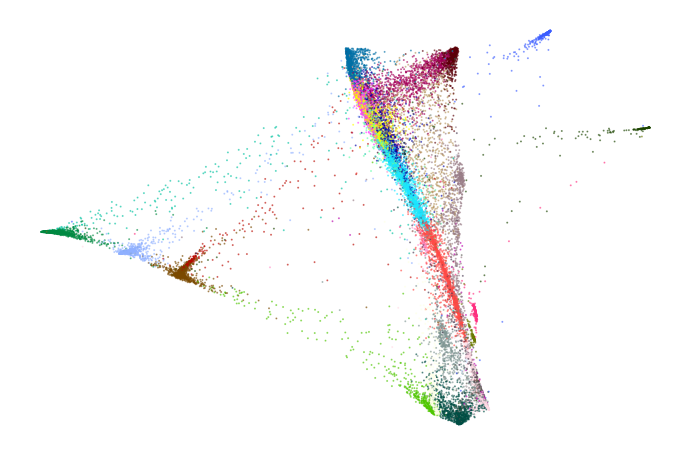

In [22]:
plot(sample_embedding1, y[indices[:25000]], alpha=0.5)

In [23]:
%time sample_embedding2 = sample_embedding1.optimize(n_iter=750, exaggeration=1, momentum=0.8)

Iteration   50, KL divergence  1.5281, 50 iterations in 6.0649 sec
Iteration  100, KL divergence  1.3389, 50 iterations in 5.9886 sec
Iteration  150, KL divergence  1.2583, 50 iterations in 6.0416 sec
Iteration  200, KL divergence  1.2150, 50 iterations in 6.1720 sec
Iteration  250, KL divergence  1.1948, 50 iterations in 6.3710 sec
Iteration  300, KL divergence  1.1771, 50 iterations in 6.5037 sec
Iteration  350, KL divergence  1.1670, 50 iterations in 6.4721 sec
Iteration  400, KL divergence  1.1595, 50 iterations in 7.4812 sec
Iteration  450, KL divergence  1.1536, 50 iterations in 6.7223 sec
Iteration  500, KL divergence  1.1494, 50 iterations in 6.9380 sec
Iteration  550, KL divergence  1.1456, 50 iterations in 7.0739 sec
Iteration  600, KL divergence  1.1432, 50 iterations in 6.9761 sec
Iteration  650, KL divergence  1.1411, 50 iterations in 6.8439 sec
Iteration  700, KL divergence  1.1397, 50 iterations in 6.8502 sec
Iteration  750, KL divergence  1.1383, 50 iterations in 6.8580

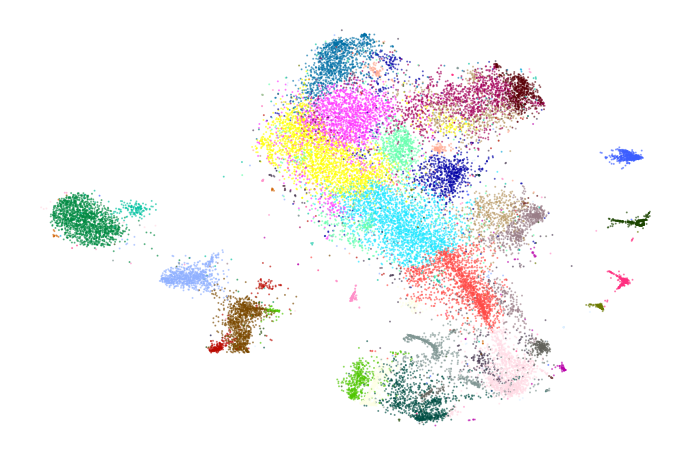

In [24]:
plot(sample_embedding2, y[indices[:25000]], alpha=0.5)

### Learn the full embedding

In [25]:
%time rest_init = sample_embedding2.prepare_partial(x_rest, k=1, perplexity=1/3)

CPU times: user 50 s, sys: 1.72 s, total: 51.7 s
Wall time: 37.7 s


In [26]:
init_full = np.vstack((sample_embedding2, rest_init))[reverse]

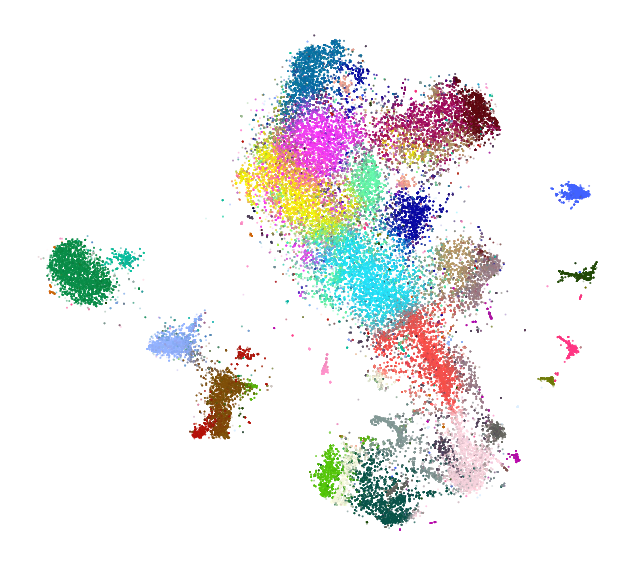

In [27]:
fig, ax = plt.subplots(figsize=(11, 10))
plot(init_full, y, ax=ax)

In [28]:
init_full = init_full / (np.std(init_full[:, 0]) * 10000)
np.std(init_full, axis=0)

array([0.0001    , 0.00011403])

In [29]:
embedding = TSNEEmbedding(
    init_full,
    affinities,
    learning_rate=1000,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
    random_state=42,
)

In [30]:
%time embedding1 = embedding.optimize(n_iter=500, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  10.2843, 50 iterations in 84.8886 sec
Iteration  100, KL divergence  10.2803, 50 iterations in 83.2534 sec
Iteration  150, KL divergence  9.3190, 50 iterations in 83.9699 sec
Iteration  200, KL divergence  8.7463, 50 iterations in 170.2522 sec
Iteration  250, KL divergence  8.5086, 50 iterations in 224.0651 sec
Iteration  300, KL divergence  8.3858, 50 iterations in 210.9331 sec
Iteration  350, KL divergence  8.3118, 50 iterations in 202.5495 sec
Iteration  400, KL divergence  8.2644, 50 iterations in 208.5362 sec
Iteration  450, KL divergence  8.2318, 50 iterations in 215.3144 sec
Iteration  500, KL divergence  8.2095, 50 iterations in 206.5496 sec
CPU times: user 1h 24min 3s, sys: 21min 19s, total: 1h 45min 22s
Wall time: 28min 14s


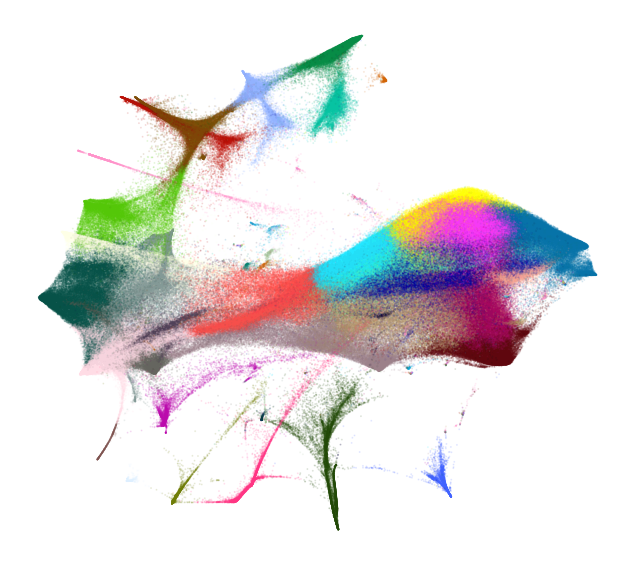

In [31]:
fig, ax = plt.subplots(figsize=(11, 10))
plot(embedding1 @ rotate(90), y, ax=ax)

In [32]:
%time embedding2 = embedding1.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.6484, 50 iterations in 218.5987 sec
Iteration  100, KL divergence  7.4664, 50 iterations in 209.4354 sec
Iteration  150, KL divergence  7.3579, 50 iterations in 210.6941 sec
Iteration  200, KL divergence  7.2860, 50 iterations in 207.8783 sec
Iteration  250, KL divergence  7.2353, 50 iterations in 201.8076 sec
CPU times: user 40min 52s, sys: 14min 3s, total: 54min 55s
Wall time: 17min 34s


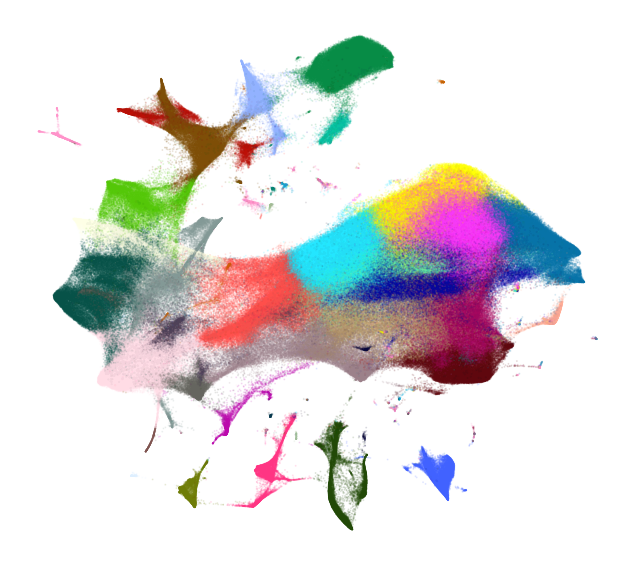

In [33]:
fig, ax = plt.subplots(figsize=(11, 10))
plot(embedding2 @ rotate(90), y, ax=ax)

In [34]:
%time embedding3 = embedding2.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.2002, 50 iterations in 208.8301 sec
Iteration  100, KL divergence  7.1705, 50 iterations in 146.0506 sec
Iteration  150, KL divergence  7.1464, 50 iterations in 82.0394 sec
Iteration  200, KL divergence  7.1272, 50 iterations in 82.2034 sec
Iteration  250, KL divergence  7.1109, 50 iterations in 122.4318 sec
CPU times: user 40min 16s, sys: 6min 40s, total: 46min 57s
Wall time: 10min 46s


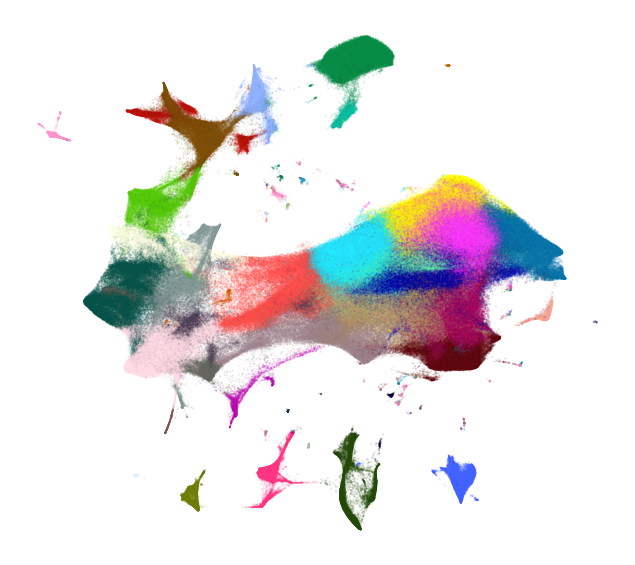

In [35]:
fig, ax = plt.subplots(figsize=(11, 10))
plot(embedding3 @ rotate(90), y, ax=ax)

In [36]:
%time embedding4 = embedding3.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.0983, 50 iterations in 210.3227 sec
Iteration  100, KL divergence  7.0863, 50 iterations in 213.1101 sec
Iteration  150, KL divergence  7.0753, 50 iterations in 208.9319 sec
Iteration  200, KL divergence  7.0660, 50 iterations in 206.6566 sec
Iteration  250, KL divergence  7.0571, 50 iterations in 220.0835 sec
CPU times: user 41min 41s, sys: 14min 2s, total: 55min 44s
Wall time: 17min 45s


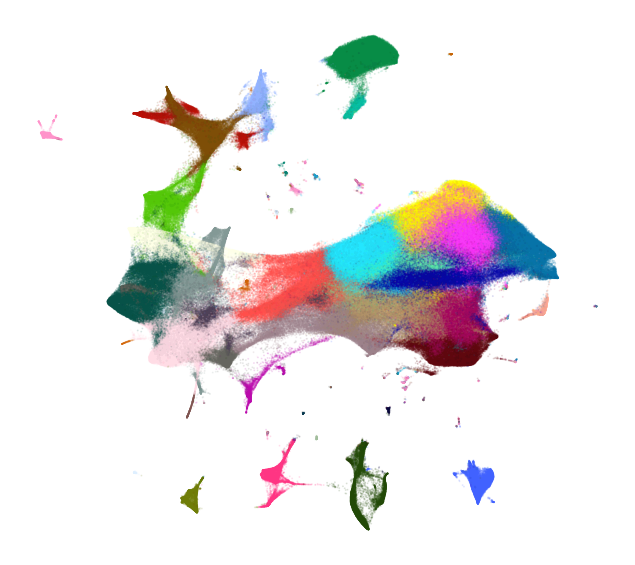

In [37]:
fig, ax = plt.subplots(figsize=(11, 10))
plot(embedding4 @ rotate(90), y, ax=ax)

## Comparison to UMAP

In [38]:
from umap import UMAP

In [39]:
umap = UMAP(n_neighbors=15, min_dist=0.1, random_state=1)

In [40]:
%time embedding_umap = umap.fit_transform(x)

CPU times: user 2h 42min 35s, sys: 13min 32s, total: 2h 56min 7s
Wall time: 1h 19min 51s


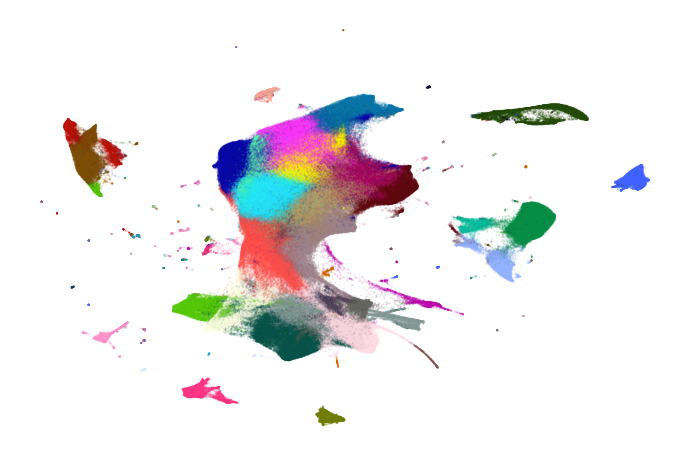

In [41]:
plot(embedding_umap, y)